<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">

# **Algoritmos Evolutivos**

> **Carrera de Especialización en Inteligencia Artificial, Facultad de Ingeniería**
>
> **Universidad de Buenos Aires, Octubre de 2024**
>
> Edgar David Guarin Castro (davidg@marketpsychdata.com)
>
> Federico Otero (fede.e.otero@gmail.com)

# **TP 3: PSO con restricciones**

## **Importando librerías**

In [1]:
# Importo las librerías
import matplotlib.pyplot as plt
import numpy as np
import math

## **Ejercicio 1**

Una fábrica produce cuatro tipos de partes automotrices. Cada una de ellas primero se fabrica y luego se le dan los acabados. Las horas de trabajador requeridas y la utilidad para cada parte son las siguientes:

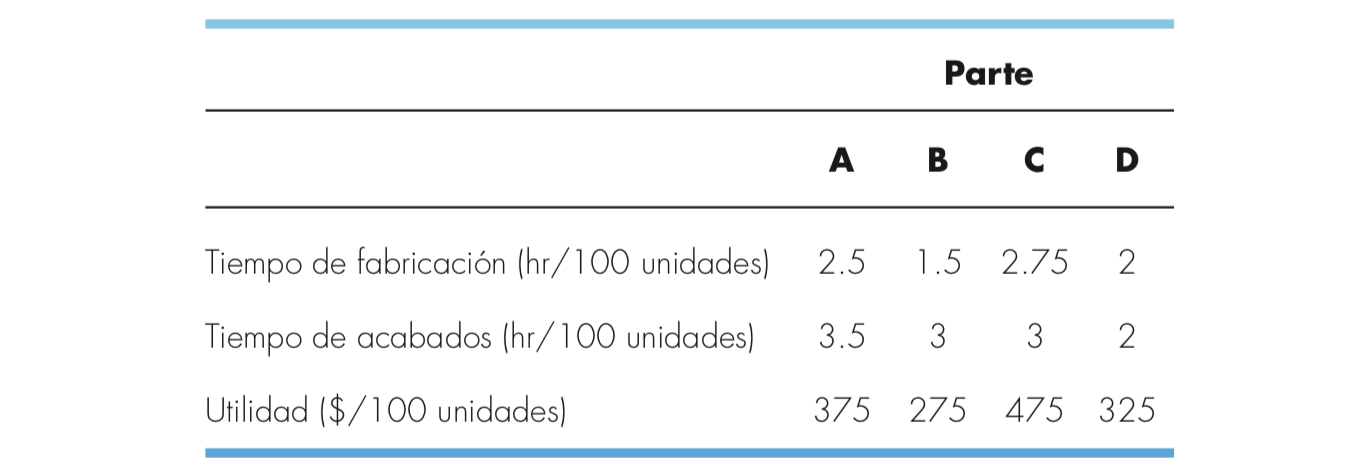

Las capacidades de los talleres de fabricación y acabados para el mes siguiente son de 640 y 960 horas, respectivamente. Determinar mediante un algoritmo PSO con restricciones (sin usar bibliotecas para PSO) que cantidad de cada partes debe producirse a fin de maximizar la utilidad y resolver las siguientes consignas:

**a. (Valor 0.33 puntos) Transcribir el algoritmo escrito en Python a un archivo .pdf de acuerdo a los siguientes parámetros: número de partículas = 20, máximo número de iteraciones 50, coeficientes de aceleración c1 = c2 = 1.4944, factor de inercia w = 0.6.**

Solución:

Modelamos este problema de la siguiente manera:

Queremos **maximizar** la utilidad:

\begin{equation*}
    U = 375 x_1 + 275 x_2 + 475 x_3 + 325 x_4
\end{equation*}

donde $x_i$ ($i=1,2,3,4$) representa la cantidad de partes que deben ser producidas. La solución debe estar sujeta a las siguientes restricciones de capacidad de fabricación:

\begin{align*}
    2.5 x_1 + 1.5 x_2 + 2.75 x_3 + 2 x_4 &\leq 640 \\
    3.5 x_1 + 3 x_2 + 3 x_3 + 2 x_4 &\leq 960
\end{align*}

Con base en esto, se definen la función objetivo, las restricciones y los parámetros del problema:

In [81]:
# Función objetivo a maximizar
def f(x):
    return 375 * x[0] + 275 * x[1] + 475 * x[2] + 325 * x[3]  # U = 375 * x1 + 275 * x2 + 475 * x3 + 325 * x4


# Primera restriccion: Tiempo de fabricación
def g1(x):
    return 2.5 * x[0] + 1.5 * x[1] + 2.75 * x[2] + 2 * x[3]  <= 640  # restriccion: 2.5 * x1 + 1.5 * x2 + 2.75 * x3 + 2 * x4 <= 640


# Segunda restriccion: Tiempo de acabado
def g2(x):
    return 3.5 * x[0] + 3 * x[1] + 3 * x[2] + 2 * x[3] <= 960  # restriccion: 3.5 * x1 + 3 * x2 + 3 * x3 + 2 * x4 <= 960

# parametros
n_particles = 20 
n_dimensions = 4
max_iterations = 50
c1 = c2 = 1.4944
w = 0.6

Luego, se define la función pso_maximizacion para ejecutar el proceso de optimización con el algoritmo PSO varias veces y de este modo garantizar que se encuentre el máximo global.

No obstante, hay que considerar en este caso que aunque las partículas se inicializan con valores aleatorios entre 0 y 100, durante el proceso de actualización por PSO, las partículas pueden moverse fuera de este rango y tomar valores negativos. Esto hace que las soluciones para las $x_i$ puedan ser negativas también.

Esto no tiene ningún sentido en el contexto del problema, ya que significaría que hay una producción negativa de partes donde se están "quitando" o "destruyendo" partes aún no fabricadas.

Para evitar esta incongruencia, se impone una restricción explícita en el algoritmo que impide que las variables $x_i$ tomen valores negativos. Para ello, se usa la función np.clip() que permite limitar los valores de las $x_i$ a un rango mínimo de 0 durante la actualización de las posiciones en el algoritmo PSO:


In [66]:
# Función que ejecuta el PSO y devuelve la mejor solución encontrada y su histórico
def pso_maximizacion():
    # Inicialización de partículas
    x = np.zeros((n_particles, n_dimensions))
    v = np.zeros((n_particles, n_dimensions))
    pbest = np.zeros((n_particles, n_dimensions))
    pbest_fit = -np.inf * np.ones(n_particles)
    gbest = np.zeros(n_dimensions)
    gbest_fit = -np.inf

    # Inicializar partículas factibles
    for i in range(n_particles):
        while True:
            x[i] = np.random.uniform(0, 100, n_dimensions)
            if g1(x[i]) and g2(x[i]):
                break
        v[i] = np.random.uniform(-1, 1, n_dimensions)
        pbest[i] = x[i].copy()
        fit = f(x[i])
        if fit > pbest_fit[i]:
            pbest_fit[i] = fit

    # Optimización
    gbest_fit_iterations = [] # Guarda el histórico del mejor resultado
    for _ in range(max_iterations):
        for i in range(n_particles):
            fit = f(x[i])
            # Comprobar si la nueva aptitud es mejor y cumple las restricciones
            if fit > pbest_fit[i] and g1(x[i]) and g2(x[i]):
                pbest_fit[i] = fit
                pbest[i] = x[i].copy()
                if fit > gbest_fit:
                    gbest_fit = fit
                    gbest = x[i].copy()

            # Actualización de la velocidad y la posición de la partícula
            v[i] = w * v[i] + c1 * np.random.rand() * (pbest[i] - x[i]) + c2 * np.random.rand() * (gbest - x[i])
            x[i] += v[i]

            # Limitar las cantidades a un mínimo de 0
            x[i] = np.clip(x[i], 0, None)  # Esto garantiza que las cantidades no sean negativas

            # Revertir la actualización si las restricciones no se cumplen
            if not (g1(x[i]) and g2(x[i])):
                x[i] = pbest[i].copy()

        # Guardar el mejor valor encontrado en la iteración
        gbest_fit_iterations.append(gbest_fit)

    return gbest, gbest_fit, gbest_fit_iterations

El proceso de optimización se ejecuta 100 veces para obtener los mejores resultados. Las mejores soluciones del número de partes, son redondeadas para darles un mejor sentido de acuerdo al contexto del problema:

In [70]:
# Ejecutar el PSO 100 veces y guardar los resultados
num_rodadas = 100
resultados_rodadas = []

for _ in range(num_rodadas):
    gbest, gbest_fit, gbest_fit_iterations = pso_maximizacion()
    resultados_rodadas.append((gbest, gbest_fit, gbest_fit_iterations))

# Seleccionar la mejor solución de todas las rodadas
mejor_solucion, mejor_valor, mejor_historico = max(resultados_rodadas, key=lambda x: x[1])

# Redondear los valores de la mejor solución al entero más cercano
mejor_solucion_redondeada = np.round(mejor_solucion)

# Imprimir la mejor solución encontrada
print(f"Mejor solucion: [{mejor_solucion_redondeada[0]}, {mejor_solucion_redondeada[1]}, {mejor_solucion_redondeada[2]}, {mejor_solucion_redondeada[3]}]")
print(f"Valor optimo: {mejor_valor}")

Mejor solucion: [0.0, 175.0, 135.0, 3.0]
Valor optimo: 113252.18623022226


**b. (Valor 0.33 puntos) Transcribir al .pdf la solución óptima encontrada (dominio) y el valor objetivo óptimo (imagen).**

Solución:

La solución óptima encontrada es: [0, 175, 135, 3].

El valor objetivo óptimo encontrado es: 113252.

Es decir, si se dejan de producir partes del tipo A, se producen pocas partes del tipo D y la producción se enfoca en producir partes del tipo B y C, las utilidades de la empresa aumentarán a más de $113 mil.


**c. (Valor 0.33 puntos) Indicar en el .pdf la URL del repositorio en donde se encuentra el algoritmo PSO.**

Solución:

Este notebook se puede encontrar en el siguiente repositorio: https://github.com/fede0ter0/ceia_algoritmos_evolutivos.git carpeta TP3.

**d. (Valor 0.5 puntos) Realizar un gráfico de línea que muestre gbest (eje de ordenadas) en función de las iteraciones realizadas (eje de abscisas). El gráfico debe contener etiquetas en los ejes, leyenda y un título. El gráfico debe ser pegado en el .pdf.**

Solución:

El gráfico es generado de la siguiente forma:

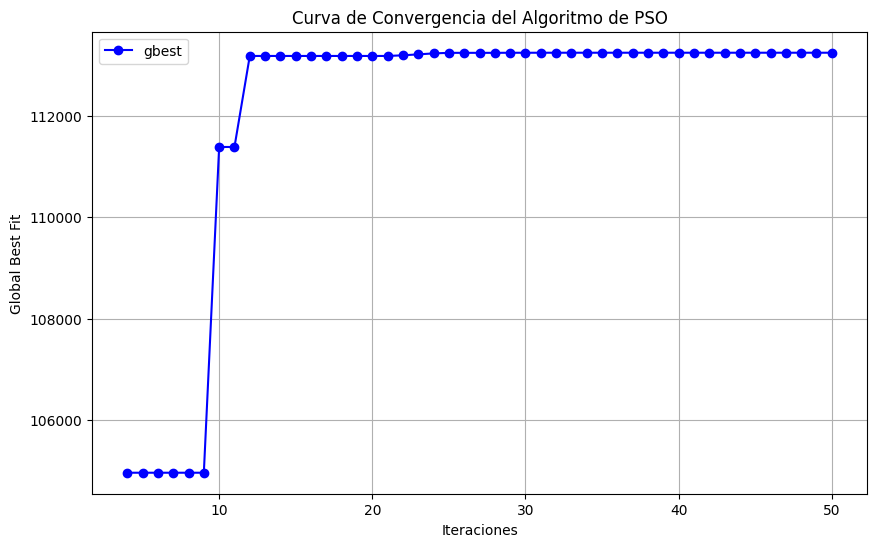

In [72]:
# Graficar el histórico de gbest en función de las iteraciones
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_iterations + 1), mejor_historico, marker='o', linestyle='-', color='b', label='gbest')
plt.title('Curva de Convergencia del Algoritmo de PSO')
plt.xlabel('Iteraciones')
plt.ylabel('Global Best Fit')
plt.legend()
plt.grid()
plt.show()

El gráfico muestra que el valor óptimo de las utilidades aumenta rápidamente durante las primeras iteraciones y luego se estabiliza, lo que indica que el algoritmo está convergiendo a una solución óptima.

El incremento rápido en el valor óptimo al principio sugiere que las partículas encuentran rápidamente una región prometedora en el espacio de búsqueda que maximiza la función objetivo. Después de aproximadamente 10 iteraciones, el valor óptimo se estabiliza, indicando que el algoritmo ha encontrado una solución óptima o se encuentra cerca de ella. Las pequeñas fluctuaciones pueden ser debidas a la exploración fina en las últimas iteraciones.

**e. (Valor 0.5 puntos) Explicar (en el .pdf) y demostrar (desde el código fuente) que sucede si se reduce en 1 unidad el tiempo de acabado de la parte B.**

Solución:

Para ver qué sucede si se reduce en 1 unidad el tiempo de acabado de la parte B, debemos actualizar la segunda condición:

In [73]:
# Actualizamos la segunda restriccion: Tiempo de acabado
def g2(x):
    return 3.5 * x[0] + 2 * x[1] + 3 * x[2] + 2 * x[3] <= 960  # restriccion original: 3.5 * x1 + 3 * x2 + 3 * x3 + 2 * x4 <= 960


y ejecutamos el proceso de optimización por PSO:

In [79]:
# Ejecutar el PSO 100 veces y guardar los resultados
num_rodadas = 100
resultados_rodadas = []

for _ in range(num_rodadas):
    gbest, gbest_fit, gbest_fit_iterations = pso_maximizacion()
    resultados_rodadas.append((gbest, gbest_fit, gbest_fit_iterations))

# Seleccionar la mejor solución de todas las rodadas
mejor_solucion, mejor_valor, mejor_historico = max(resultados_rodadas, key=lambda x: x[1])

# Redondear los valores de la mejor solución al entero más cercano
mejor_solucion_redondeada = np.round(mejor_solucion)

# Imprimir la mejor solución encontrada
print(f"Mejor solucion: [{mejor_solucion_redondeada[0]}, {mejor_solucion_redondeada[1]}, {mejor_solucion_redondeada[2]}, {mejor_solucion_redondeada[3]}]")
print(f"Valor optimo: {mejor_valor}")

Mejor solucion: [1.0, 297.0, 70.0, 0.0]
Valor optimo: 115235.24179344307


El resultado es un poco mejor que en el caso anterior:

La solución óptima encontrada es: [1, 297, 70, 0].

El valor objetivo óptimo encontrado es: 115235.

En otras palabras, reducir en una unidad el tiempo de acabado de las partes del tipo B, aumenta el número de piezas fabricadas de este tipo de 175 a 297 y en consecuencia, las utilidades aumentan $2 mil aproximadamente. Sin embargo, este cambio afecta el número de piezas fabricadas de otros tipos.

El siguiente gráfico muestra la evolución del valor óptimo para este caso:

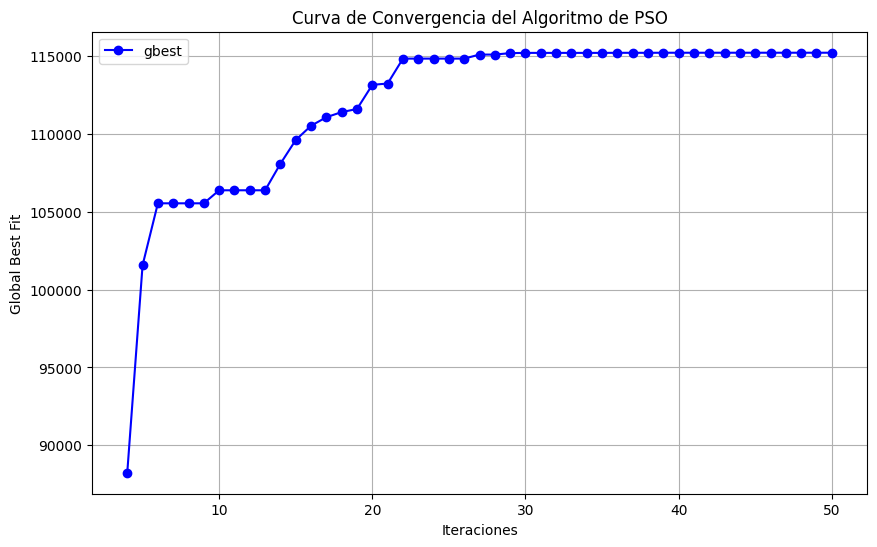

In [80]:
# Graficar el histórico de gbest en función de las iteraciones
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_iterations + 1), mejor_historico, marker='o', linestyle='-', color='b', label='gbest')
plt.title('Curva de Convergencia del Algoritmo de PSO')
plt.xlabel('Iteraciones')
plt.ylabel('Global Best Fit')
plt.legend()
plt.grid()
plt.show()

Se nota que aquí la convergencia es más lenta y presenta más escalones donde el algoritmo intentó estabilizar pero al final encontró regiones más prometedoras.

**f. (Valor 1 punto) Realizar 3 boxplots a partir de los gbest de 3 variantes de solución: i) El primer boxplot con el coeficiente de inercia constante w = 0.8, ii) El segundo boxplot con el coeficiente de inercia dinámico lineal y iii) El tercer boxplot sin coeficiente de inercia pero aplicando Factor de constricción con φ a elección.**

Solución:

Primero, reestablecemos la segunda condición:

In [82]:
# Actualizamos la segunda restriccion: Tiempo de acabado
def g2(x):
    return 3.5 * x[0] + 3 * x[1] + 3 * x[2] + 2 * x[3] <= 960  # restriccion original: 3.5 * x1 + 3 * x2 + 3 * x3 + 2 * x4 <= 960

- Optimizamos para la primera variante con w = 0.8:

In [116]:
w = 0.8

# Ejecutar el PSO 100 veces y guardar los resultados
num_rodadas = 100
resultados_rodadas = []

for _ in range(num_rodadas):
    gbest, gbest_fit, gbest_fit_iterations = pso_maximizacion()
    resultados_rodadas.append((gbest, gbest_fit, gbest_fit_iterations))

# Seleccionar la mejor solución de todas las rodadas
mejor_solucion, mejor_valor, mejor_historico = max(resultados_rodadas, key=lambda x: x[1])

# Redondear los valores de la mejor solución al entero más cercano
mejor_solucion_redondeada = np.round(mejor_solucion)

# Imprimir la mejor solución encontrada
print(f"Mejor solucion: [{mejor_solucion_redondeada[0]}, {mejor_solucion_redondeada[1]}, {mejor_solucion_redondeada[2]}, {mejor_solucion_redondeada[3]}]")
print(f"Valor optimo: {mejor_valor}")

Mejor solucion: [0.0, 197.0, 105.0, 27.0]
Valor optimo: 112746.13705425602


Los resultados indican que un aumento de w hace que le sea más difícil al algoritmo alcanzar el máximo global y acaba cayendo en un máximo cercano menor al encontrado con w=0.6.

La evolución del valor óptimo en este caso se muestra a continuación:

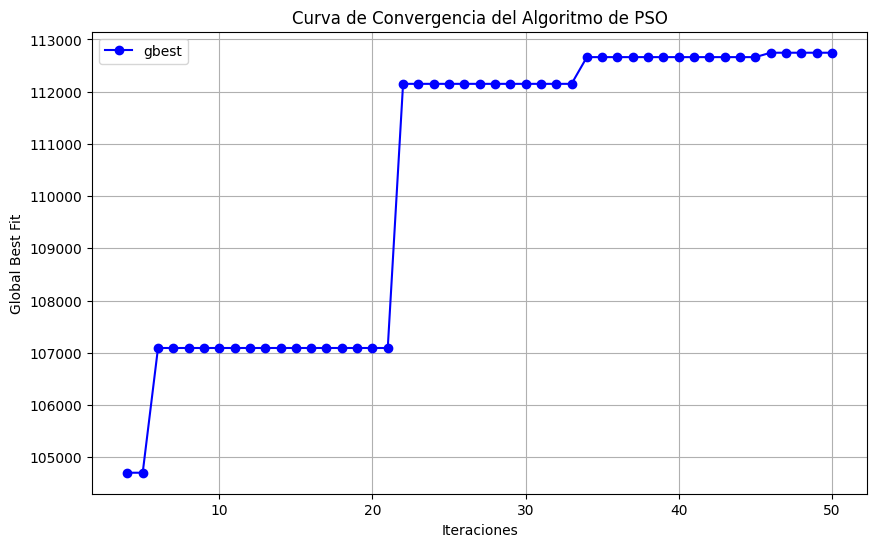

In [117]:
# Graficar el histórico de gbest en función de las iteraciones
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_iterations + 1), mejor_historico, marker='o', linestyle='-', color='b', label='gbest')
plt.title('Curva de Convergencia del Algoritmo de PSO')
plt.xlabel('Iteraciones')
plt.ylabel('Global Best Fit')
plt.legend()
plt.grid()
plt.show()

Como era de esperarse, un aumento de w favorece una mayor exploración pero ralentiza la convergencia que en este caso ocurre después de 30 iteraciones.

El boxplot para este caso se grafica a continuación:

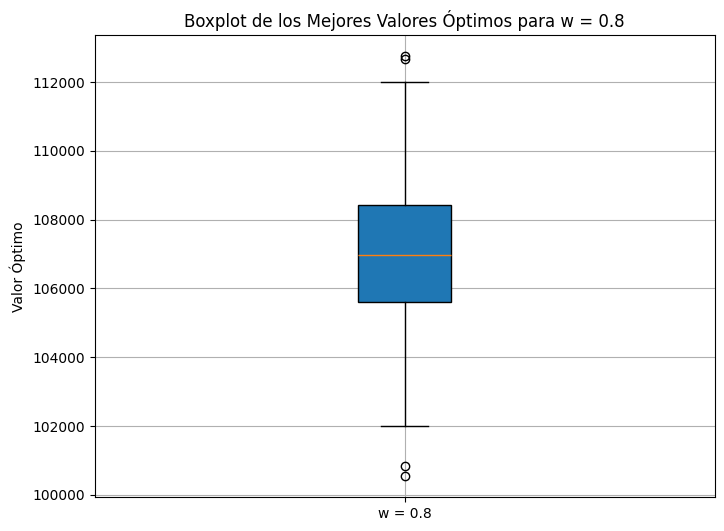

In [118]:
# Extraer los valores óptimos de los resultados obtenidos
resultados_vi = [resultado[1] for resultado in resultados_rodadas]  # Aquí usamos los valores óptimos reales

# Crear el boxplot para los resultados reales
plt.figure(figsize=(8, 6))
plt.boxplot(resultados_vi, patch_artist=True, labels=['w = 0.8'])

# Añadir títulos y etiquetas
plt.title('Boxplot de los Mejores Valores Óptimos para w = 0.8')
plt.ylabel('Valor Óptimo')
plt.grid()

# Mostrar el gráfico
plt.show()

- Optimizamos para la segunda variante con un coeficiente de inercia dinámico lineal. Aquí, es necesario modificar la función para el algoritmo PSO, ya que con un w dinámico se busca favorecer la exploración global al inicio y la explotación local hacia el final del proceso de optimización.

Para ello, se define $w$ como una función que varía de un valor inicial, $w_i$, a un valor final, $w_f$, a medida que avanza el número de iteraciones, $it$, de modo que:

\begin{equation*}
    w = w_i - \frac{it}{it_{max}} (w_i-w_f)
\end{equation*}

donde $it_{max}$ es el número máximo de iteraciones. Implementando esta idea, se tiene que:

In [119]:
# Función que ejecuta el PSO y devuelve la mejor solución encontrada y su histórico
def pso_max_dinamico():
    # Inicialización de partículas
    x = np.zeros((n_particles, n_dimensions))
    v = np.zeros((n_particles, n_dimensions))
    pbest = np.zeros((n_particles, n_dimensions))
    pbest_fit = -np.inf * np.ones(n_particles)
    gbest = np.zeros(n_dimensions)
    gbest_fit = -np.inf

    # Parámetros de inercia
    w_inicio = 0.9
    w_fin = 0.2

    # Inicializar partículas factibles
    for i in range(n_particles):
        while True:
            x[i] = np.random.uniform(0, 100, n_dimensions)
            if g1(x[i]) and g2(x[i]):
                break
        v[i] = np.random.uniform(-1, 1, n_dimensions)
        pbest[i] = x[i].copy()
        fit = f(x[i])
        if fit > pbest_fit[i]:
            pbest_fit[i] = fit

    # Optimización
    gbest_fit_iterations = []
    for iter_num in range(max_iterations):
        # Actualizar el coeficiente de inercia de forma lineal
        w = w_inicio - ((w_inicio - w_fin) * (iter_num / max_iterations))

        for i in range(n_particles):
            fit = f(x[i])
            # Comprobar si la nueva aptitud es mejor y cumple las restricciones
            if fit > pbest_fit[i] and g1(x[i]) and g2(x[i]):
                pbest_fit[i] = fit
                pbest[i] = x[i].copy()
                if fit > gbest_fit:
                    gbest_fit = fit
                    gbest = x[i].copy()

            # Actualización de la velocidad y la posición de la partícula
            v[i] = w * v[i] + c1 * np.random.rand() * (pbest[i] - x[i]) + c2 * np.random.rand() * (gbest - x[i])
            x[i] += v[i]

            # Limitar las cantidades a un mínimo de 0
            x[i] = np.clip(x[i], 0, None)  # Esto garantiza que las cantidades no sean negativas

            # Revertir la actualización si las restricciones no se cumplen
            if not (g1(x[i]) and g2(x[i])):
                x[i] = pbest[i].copy()

        # Guardar el mejor valor encontrado en la iteración
        gbest_fit_iterations.append(gbest_fit)

    return gbest, gbest_fit, gbest_fit_iterations

Con el nuevo algoritmo, se ejecuta varias veces para obtener el mejor valor óptimo:

In [123]:
# Ejecutar el PSO 100 veces y guardar los resultados
num_rodadas = 100
resultados_rodadas = []

for _ in range(num_rodadas):
    gbest, gbest_fit, gbest_fit_iterations = pso_max_dinamico()
    resultados_rodadas.append((gbest, gbest_fit, gbest_fit_iterations))

# Seleccionar la mejor solución de todas las rodadas
mejor_solucion, mejor_valor, mejor_historico = max(resultados_rodadas, key=lambda x: x[1])

# Redondear los valores de la mejor solución al entero más cercano
mejor_solucion_redondeada = np.round(mejor_solucion)

# Imprimir la mejor solución encontrada
print(f"Mejor solucion: [{mejor_solucion_redondeada[0]}, {mejor_solucion_redondeada[1]}, {mejor_solucion_redondeada[2]}, {mejor_solucion_redondeada[3]}]")
print(f"Valor optimo: {mejor_valor}")

Mejor solucion: [0.0, 182.0, 128.0, 7.0]
Valor optimo: 113290.81985024869


Los resultados muestran que se obtiene un valor óptimo semejante al valor registrado con w=0.6.

La evolución del valor óptimo en este caso se muestra a continuación:

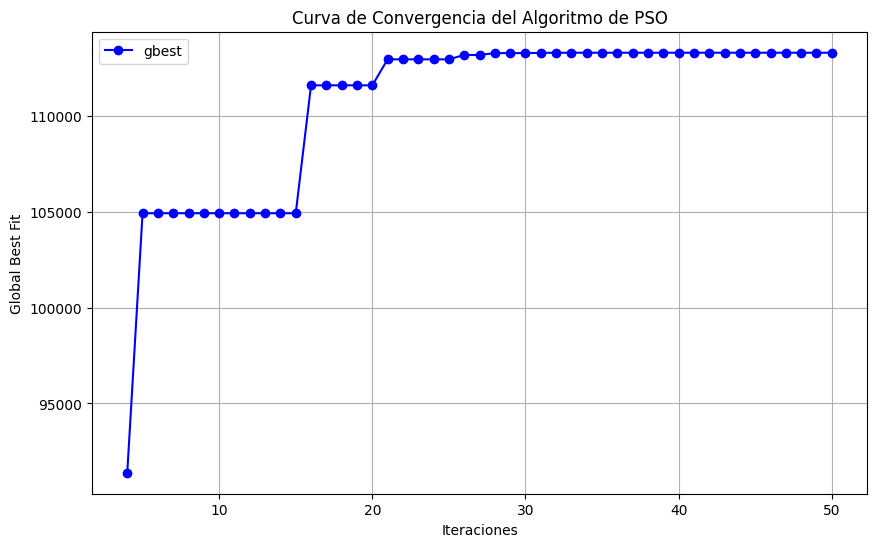

In [124]:
# Graficar el histórico de gbest en función de las iteraciones
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_iterations + 1), mejor_historico, marker='o', linestyle='-', color='b', label='gbest')
plt.title('Curva de Convergencia del Algoritmo de PSO')
plt.xlabel('Iteraciones')
plt.ylabel('Global Best Fit')
plt.legend()
plt.grid()
plt.show()

El gráfico sugiere que el algoritmo PSO, con el coeficiente de inercia dinámico, está funcionando de manera efectiva para encontrar una solución óptima. La rápida convergencia inicial seguida por una búsqueda más fina y la estabilización final indica que el algoritmo exploró y explotó el espacio de búsqueda adecuadamente. La estabilización del valor óptimo cerca de las 30 iteraciones sugiere que el número de iteraciones es suficiente para obtener una buena solución. Sin embargo, no se ven ventajas significativas en relación al caso de w=0.6.

El boxplot para este caso se muestra a continuación:

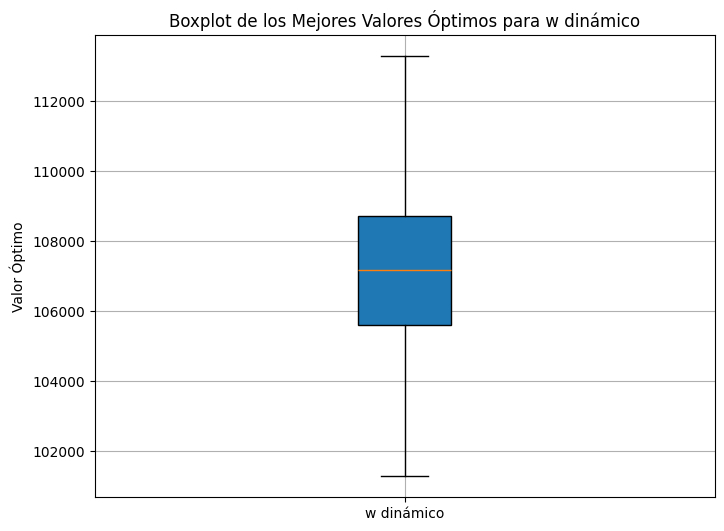

In [125]:
# Extraer los valores óptimos de los resultados obtenidos
resultados_vii = [resultado[1] for resultado in resultados_rodadas]  # Aquí usamos los valores óptimos reales

# Crear el boxplot para los resultados reales
plt.figure(figsize=(8, 6))
plt.boxplot(resultados_vii, patch_artist=True, labels=['w dinámico'])

# Añadir títulos y etiquetas
plt.title('Boxplot de los Mejores Valores Óptimos para w dinámico')
plt.ylabel('Valor Óptimo')
plt.grid()

# Mostrar el gráfico
plt.show()

- Optimizamos para la tercera variante, sin coeficiente de inercia pero con factor de constricción.

El factor de constricción $\chi$ se calcula utilizando el parámetro $\phi = c1 + c2$ de la siguiente forma:

\begin{equation*}
    \chi = \frac{2}{|\phi - 2 + \sqrt{\phi^2 - 4\phi}|}
\end{equation*}

donde $\phi$ debe ser mayor que 4 para asegurar que el valor dentro de la raíz cuadrada sea positivo. Por ende, c1 y c2 deben ser mayores a 2. La introducción de este factor afecta la actualización de las velocidades en el algoritmo PSO, de modo que el nuevo algoritmo queda:

In [126]:
# Función que ejecuta el PSO con el factor de constricción y devuelve la mejor solución encontrada y su histórico
def pso_max_constriccion():
    # Parámetros de PSO
    c1 = c2 = 2.05  # Constantes cognitivas y sociales
    phi = c1 + c2
    chi = 2 / abs(phi - 2 + np.sqrt(phi**2 - 4 * phi))  # Factor de constricción

    # Inicialización de partículas
    x = np.zeros((n_particles, n_dimensions))
    v = np.zeros((n_particles, n_dimensions))
    pbest = np.zeros((n_particles, n_dimensions))
    pbest_fit = -np.inf * np.ones(n_particles)
    gbest = np.zeros(n_dimensions)
    gbest_fit = -np.inf

    # Inicializar partículas factibles
    for i in range(n_particles):
        while True:
            x[i] = np.random.uniform(0, 100, n_dimensions)
            if g1(x[i]) and g2(x[i]):
                break
        v[i] = np.random.uniform(-1, 1, n_dimensions)
        pbest[i] = x[i].copy()
        fit = f(x[i])
        if fit > pbest_fit[i]:
            pbest_fit[i] = fit

    # Optimización
    gbest_fit_iterations = []
    for _ in range(max_iterations):
        for i in range(n_particles):
            fit = f(x[i])
            # Comprobar si la nueva aptitud es mejor y cumple las restricciones
            if fit > pbest_fit[i] and g1(x[i]) and g2(x[i]):
                pbest_fit[i] = fit
                pbest[i] = x[i].copy()
                if fit > gbest_fit:
                    gbest_fit = fit
                    gbest = x[i].copy()

            # Actualización de la velocidad y la posición de la partícula con el factor de constricción
            r1, r2 = np.random.rand(), np.random.rand()
            v[i] = chi * (c1 * r1 * (pbest[i] - x[i]) + c2 * r2 * (gbest - x[i]))
            x[i] += v[i]

            # Limitar las cantidades a un mínimo de 0
            x[i] = np.clip(x[i], 0, None)  # Esto garantiza que las cantidades no sean negativas

            # Revertir la actualización si las restricciones no se cumplen
            if not (g1(x[i]) and g2(x[i])):
                x[i] = pbest[i].copy()

        # Guardar el mejor valor encontrado en la iteración
        gbest_fit_iterations.append(gbest_fit)

    return gbest, gbest_fit, gbest_fit_iterations

Con el nuevo algoritmo, se ejecuta varias veces para obtener el mejor valor óptimo:

In [128]:
# Ejecutar el PSO 100 veces y guardar los resultados
num_rodadas = 100
resultados_rodadas = []

for _ in range(num_rodadas):
    gbest, gbest_fit, gbest_fit_iterations = pso_max_constriccion()
    resultados_rodadas.append((gbest, gbest_fit, gbest_fit_iterations))

# Seleccionar la mejor solución de todas las rodadas
mejor_solucion, mejor_valor, mejor_historico = max(resultados_rodadas, key=lambda x: x[1])

# Redondear los valores de la mejor solución al entero más cercano
mejor_solucion_redondeada = np.round(mejor_solucion)

# Imprimir la mejor solución encontrada
print(f"Mejor solucion: [{mejor_solucion_redondeada[0]}, {mejor_solucion_redondeada[1]}, {mejor_solucion_redondeada[2]}, {mejor_solucion_redondeada[3]}]")
print(f"Valor optimo: {mejor_valor}")

Mejor solucion: [0.0, 168.0, 141.0, 0.0]
Valor optimo: 113219.99684495784


Los resultados muestran que se obtiene un valor óptimo semejante al valor registrado con w=0.6.

La evolución del valor óptimo en este caso se muestra a continuación:

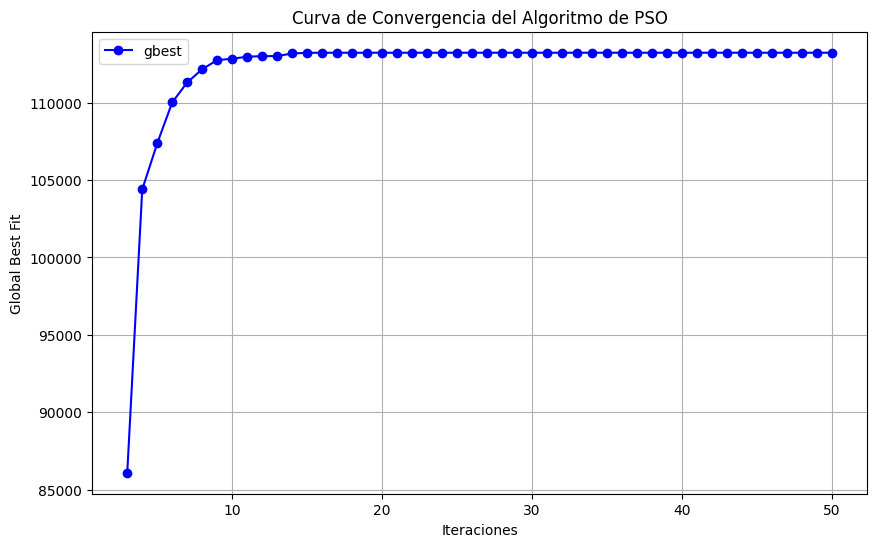

In [129]:
# Graficar el histórico de gbest en función de las iteraciones
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_iterations + 1), mejor_historico, marker='o', linestyle='-', color='b', label='gbest')
plt.title('Curva de Convergencia del Algoritmo de PSO')
plt.xlabel('Iteraciones')
plt.ylabel('Global Best Fit')
plt.legend()
plt.grid()
plt.show()

Se aprecia que con este método la convergencia es mucho más rápida que e los casos anteriores.

El boxplot para este caso se muestra a continuación:

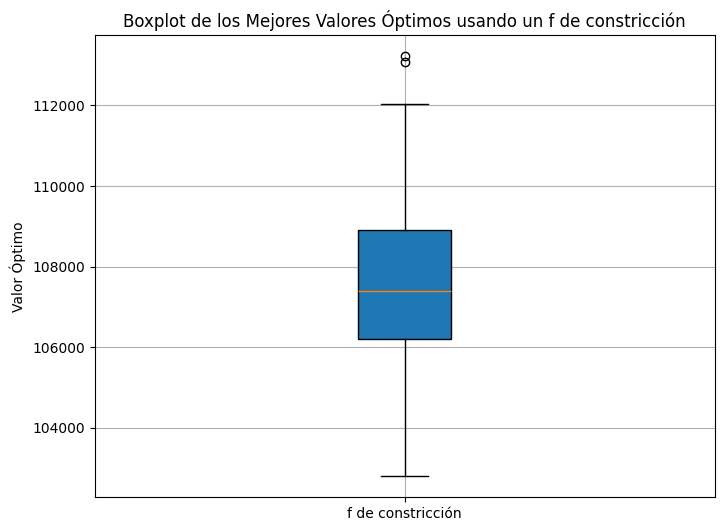

In [130]:
# Extraer los valores óptimos de los resultados obtenidos
resultados_viii = [resultado[1] for resultado in resultados_rodadas]  # Aquí usamos los valores óptimos reales

# Crear el boxplot para los resultados reales
plt.figure(figsize=(8, 6))
plt.boxplot(resultados_viii, patch_artist=True, labels=['f de constricción'])

# Añadir títulos y etiquetas
plt.title('Boxplot de los Mejores Valores Óptimos usando un f de constricción')
plt.ylabel('Valor Óptimo')
plt.grid()

# Mostrar el gráfico
plt.show()

El gráfico con los boxplots que compara los mejores valores óptimos obtenidos con las tres variantes se muestra a continuación:

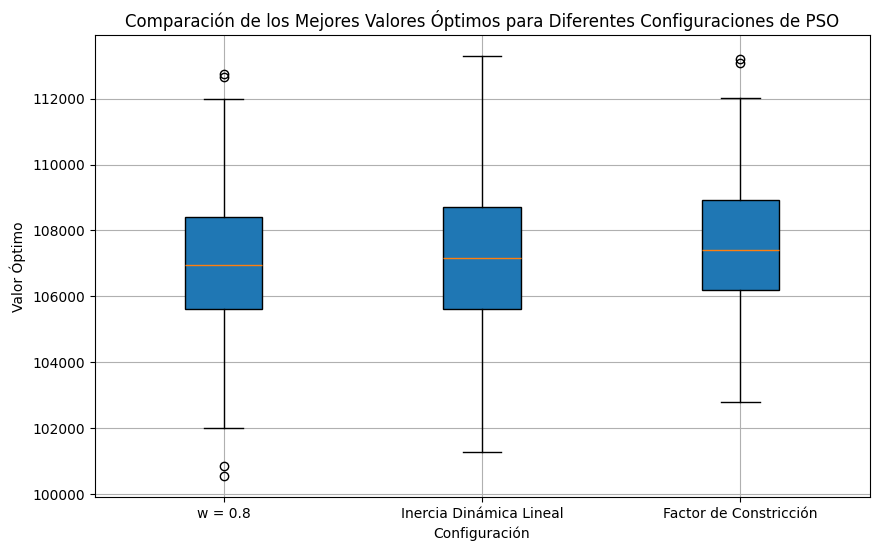

In [133]:
# Crear el boxplot para comparar los tres conjuntos de resultados reales
plt.figure(figsize=(10, 6))
plt.boxplot([resultados_vi, resultados_vii, resultados_viii], patch_artist=True,
            labels=['w = 0.8', 'Inercia Dinámica Lineal', 'Factor de Constricción'])

# Añadir títulos y etiquetas
plt.title('Comparación de los Mejores Valores Óptimos para Diferentes Configuraciones de PSO')
plt.ylabel('Valor Óptimo')
plt.xlabel('Configuración')
plt.grid()

# Mostrar el gráfico
plt.show()

**g. (Valor 1 punto) Realizar observaciones/comentarios/conclusiones en el .pdf acerca de los resultados del ítem (f).**

Solución:

El gráfico que compara los boxplots de las 3 configuraciones indica que:

- Las medianas de los valores óptimos (línea naranja) son semejantes en todos los casos y cercanas a 107000. No obstante, la configuración con factor de constricción tiene una mediana ligeramente superior, lo que sugiere que, en promedio, esta configuración tiende a encontrar mejores valores óptimos en comparación con las otras dos.

- La dispersión o variabilidad en los valores óptimos obtenidos (tamaño de las cajas) también es semjante en los 3 casos, aunque las configuraciones de inercia dinámica lineal y factor de constricción son ligeramente mayores. Esto sugiere que estas configuraciones exploran más el espacio de búsqueda, lo que puede llevar a resultados óptimos más altos en algunas ejecuciones.

- El rango de valores (barras verticales) es más estrecho para el caso de la variante con factor de constricción, indicando que la mayoría de los resultados se concentran en un rango específico. Por su parte, la variante con Inercia Dinámica Lineal tiene un rango más amplio, lo que sugiere que en algunas ejecuciones el PSO encontró valores óptimos más altos.

- Hay algunos valores atípicos en las configuraciones de w=0.8 y con factor de constricción, lo que representa valores que se alejan significativamente del rango principal de resultados. Estos valores atípicos pueden ocurrir debido a exploraciones que encontraron soluciones subóptimas o especialmente buenas.

Por lo anterior, si se busca estabilidad y consistencia en los resultados con rápida convergencia, la configuración con factor de constricción sería la mejor elección. Pero si se prefiere la posibilidad de encontrar valores óptimos más altos a costa de mayor variabilidad, la configuración con inercia dinámica lineal parece ser la más prometedora.


**h. (Valor 1 punto) Realizar observaciones/comentarios/conclusiones en el .pdf acerca de qué cantidad mínima de partículas es factible utilizar para este problema específicamente.**

Solución:

Dado que nuestro problema tiene una función objetivo lineal y restricciones también lineales, el espacio de búsqueda es más predecible y menos propenso a múltiples óptimos locales en comparación con problemas no lineales o altamente complejos. Esto sugiere que no necesitamos demasiadas partículas para cubrir de manera eficiente el espacio de búsqueda.

En términos generales, una regla empírica en PSO es que el número de partículas debería ser al menos 10 veces el número de dimensiones para garantizar una buena exploración del espacio de búsqueda. Así, utilizando 20 partículas ya conseguimos una solución muy buena, con lo cual consideramos que 10 partículas es una cantidad mínima aceptable.

## **Ejercicio 2**

Un fabricante de equipos de cómputo produce dos tipos de impresoras (impresoras de tipo 1 e impresoras de tipo 2). Los recursos necesarios para producirlas así como las utilidades correspondientes son los que siguen:

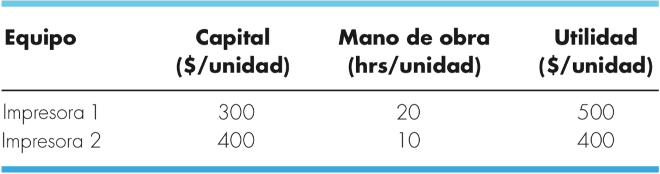

Si cada día se dispone de $127000 de capital y 4270 horas de mano de obra, ¿qué cantidad de cada equipo debe producirse a diario a fin de maximizar la utilidad? Escriba el algoritmo PSO con restricciones (sin usar bibliotecas para PSO) que permita optimizar la utilidad y resolver cumpliendo con las siguientes consignas:

**a.	(Valor 0.33 puntos) Transcribir el algoritmo escrito en Python a un archivo .pdf de acuerdo a los siguientes parámetros: número de partículas = 10, máximo número de iteraciones 80, coeficientes de aceleración c1 = c2 = 2, factor de inercia w = 0.5.**

Solución:

Se asume que la cantidad óptima de impresoras del tipo 1 es $x_1$ y del tipo 2 es $x_2$, de modo que la utilidad viene dada por:

\begin{equation*}
    U = 500 x_1 + 400 x_2
\end{equation*}

Además, las restricciones del problema son, para el capital diario:

\begin{equation*}
    300 x_1 + 400 x_2 \leq 127000
\end{equation*}

y para la mano de obra diaria:

\begin{equation*}
    20 x_1 + 10 x_2 \leq 4270
\end{equation*}

La función objetivo para la utilidad y las funciones para las restricciones se definen en la siguiente celda:

In [134]:
# Definir la función objetivo (utilidad)
def utilidad(x):
    return 500 * x[0] + 400 * x[1]

# Restricciones
def capital_restriccion(x):
    return 300 * x[0] + 400 * x[1] <= 127000

def mano_obra_restriccion(x):
    return 20 * x[0] + 10 * x[1] <= 4270

Los parámetros del problema son:

In [135]:
# Parámetros del PSO
n_particles = 10
n_dimensions = 2  # Número de impresoras (tipo 1 y tipo 2)
max_iterations = 80
c1 = c2 = 2
w = 0.5

Con base en lo anterior, el algoritmo PSO queda definido de la siguiente forma:

In [136]:
# Función que ejecuta el PSO con restricciones
def pso_maximizacion():
    # Inicialización de partículas
    x = np.zeros((n_particles, n_dimensions))
    v = np.zeros((n_particles, n_dimensions))
    pbest = np.zeros((n_particles, n_dimensions))
    pbest_fit = -np.inf * np.ones(n_particles)
    gbest = np.zeros(n_dimensions)
    gbest_fit = -np.inf

    # Inicializar partículas factibles
    for i in range(n_particles):
        while True:
            x[i] = np.random.uniform(0, 500, n_dimensions)  # Limitar la cantidad de producción a un rango razonable
            if capital_restriccion(x[i]) and mano_obra_restriccion(x[i]):
                break
        v[i] = np.random.uniform(-1, 1, n_dimensions)
        pbest[i] = x[i].copy()
        fit = utilidad(x[i])
        if fit > pbest_fit[i]:
            pbest_fit[i] = fit

    # Optimización
    gbest_fit_iterations = []
    for _ in range(max_iterations):
        for i in range(n_particles):
            fit = utilidad(x[i])
            # Comprobar si la nueva aptitud es mejor y cumple las restricciones
            if fit > pbest_fit[i] and capital_restriccion(x[i]) and mano_obra_restriccion(x[i]):
                pbest_fit[i] = fit
                pbest[i] = x[i].copy()
                if fit > gbest_fit:
                    gbest_fit = fit
                    gbest = x[i].copy()

            # Actualización de la velocidad y la posición de la partícula
            r1, r2 = np.random.rand(), np.random.rand()
            v[i] = w * v[i] + c1 * r1 * (pbest[i] - x[i]) + c2 * r2 * (gbest - x[i])
            x[i] += v[i]

            # Limitar las cantidades a un mínimo de 0 (no se pueden producir cantidades negativas)
            x[i] = np.clip(x[i], 0, None)

            # Revertir la actualización si las restricciones no se cumplen
            if not (capital_restriccion(x[i]) and mano_obra_restriccion(x[i])):
                x[i] = pbest[i].copy()

        gbest_fit_iterations.append(gbest_fit)

    return gbest, gbest_fit, gbest_fit_iterations

**b. (Valor 0.33 puntos) Transcribir al .pdf la solución óptima encontrada (dominio) y el valor objetivo óptimo (imagen).**

Solución:

Usando el algoritmo PSO se ejecuta 100 veces para garantizar la convergencia a un máximo global:

In [140]:
# Ejecutar el PSO 100 veces y guardar los resultados
num_rodadas = 100
resultados_rodadas = []

for _ in range(num_rodadas):
    gbest, gbest_fit, gbest_fit_iterations = pso_maximizacion()
    resultados_rodadas.append((gbest, gbest_fit, gbest_fit_iterations))

# Seleccionar la mejor solución de todas las rodadas
mejor_solucion, mejor_valor, mejor_historico = max(resultados_rodadas, key=lambda x: x[1])

# Redondear los valores de la mejor solución al entero más cercano
mejor_solucion_redondeada = np.round(mejor_solucion)

# Imprimir la mejor solución encontrada
print(f"Mejor solucion: [{mejor_solucion_redondeada[0]}, {mejor_solucion_redondeada[1]}]")
print(f"Valor optimo: {mejor_valor}")

Mejor solucion: [88.0, 252.0]
Valor optimo: 144519.68164455163


La mejor solucion encontrada para $x_1$ y $x_2$ fue: [88.0, 252.0]

El mejor valor óptimo encontrado fue $144520.

Por lo tanto, produciendo 88 impresoras del tipo 1 y 252 impresoras del tipo 2, diariamente se obtiene una utilidad de aproximadamente $144520.

**c. (Valor 0.33 puntos) Indicar en el .pdf la URL del repositorio en donde se encuentra el algoritmo PSO.**

Solución:

Este notebook se puede encontrar en el siguiente repositorio: https://github.com/fede0ter0/ceia_algoritmos_evolutivos.git carpeta TP3.

**d. (Valor 0.5 puntos) Realizar un gráfico de línea que muestre gbest (eje de ordenadas) en función de las iteraciones realizadas (eje de abscisas). El gráfico debe contener etiquetas en los ejes, leyenda y un título. El gráfico debe ser pegado en el .pdf.**

Solución:

La evolución del mejor valor encontrado a lo largo de las iteraciones se presenta a continuación:

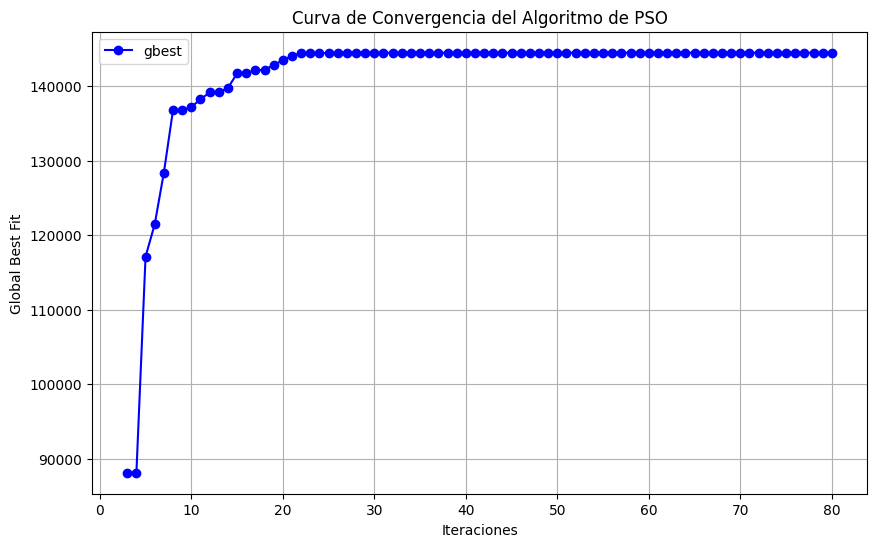

In [141]:
# Graficar el histórico de gbest en función de las iteraciones
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_iterations + 1), mejor_historico, marker='o', linestyle='-', color='b', label='gbest')
plt.title('Curva de Convergencia del Algoritmo de PSO')
plt.xlabel('Iteraciones')
plt.ylabel('Global Best Fit')
plt.legend()
plt.grid()
plt.show()

El gráfico aterior muestra que:

- Durante las primeras 10 iteraciones, hay un rápido aumento en el valor óptimo. Esto indica que las partículas del PSO están explorando activamente el espacio de búsqueda y encontrando rápidamente regiones con alta utilidad.
- Entre las iteraciones 10 y 30, la curva se vuelve más plana pero continúa aumentando lentamente. Esto sugiere que el algoritmo está realizando una búsqueda más precisa y enfocada en los alrededores de las regiones con alta utilidad que encontró al inicio.
- A partir de la iteración 30 aproximadamente, la curva se estabiliza por completo, lo que indica que el algoritmo ha convergido hacia una solución óptima o muy cercana al óptimo.
- Esta estabilización es una señal positiva de que el PSO ha logrado maximizar la función objetivo respetando las restricciones impuestas (capital y mano de obra).

**e. (Valor 0.5 puntos) Explicar (en el .pdf) y demostrar (desde el código fuente) que sucede si se reduce en 1 unidad el tiempo de acabado de la parte B.**

Solución:

Se redefine la función para la restricción del tiempo de mano de obra diaria, disminuyendo en una unidad el coeficiente del tiempo de fabricación de la impresora del tipo 2:

In [142]:
def mano_obra_restriccion(x):
    return 20 * x[0] + 9 * x[1] <= 4270

Se ejecuta nuevamente el algoritmo PSO:

In [146]:
# Ejecutar el PSO 100 veces y guardar los resultados
num_rodadas = 100
resultados_rodadas = []

for _ in range(num_rodadas):
    gbest, gbest_fit, gbest_fit_iterations = pso_maximizacion()
    resultados_rodadas.append((gbest, gbest_fit, gbest_fit_iterations))

# Seleccionar la mejor solución de todas las rodadas
mejor_solucion, mejor_valor, mejor_historico = max(resultados_rodadas, key=lambda x: x[1])

# Redondear los valores de la mejor solución al entero más cercano
mejor_solucion_redondeada = np.round(mejor_solucion)

# Imprimir la mejor solución encontrada
print(f"Mejor solucion: [{mejor_solucion_redondeada[0]}, {mejor_solucion_redondeada[1]}]")
print(f"Valor optimo: {mejor_valor}")

Mejor solucion: [107.0, 238.0]
Valor optimo: 148320.2177346839


Los resultados muestran que la mejor solución para $x_1$ y $x_2$ es: [107.0, 238.0].

El mejor valor óptimo encontrado es $148320.

Por consiguiente, disminuir en una hora el tiempo de fabricación de la impresora del tipo 2 hace que el número de impresoras de este tipo producidas diariamente caiga de 252 a 238, pero el número de impresoras del tipo 1 aumenta de 88 a 107, lo que implica en un aumento en las utilidades de $3800.

La evolución del mejor valor encontrado a lo largo de las iteraciones se presenta a continuación:

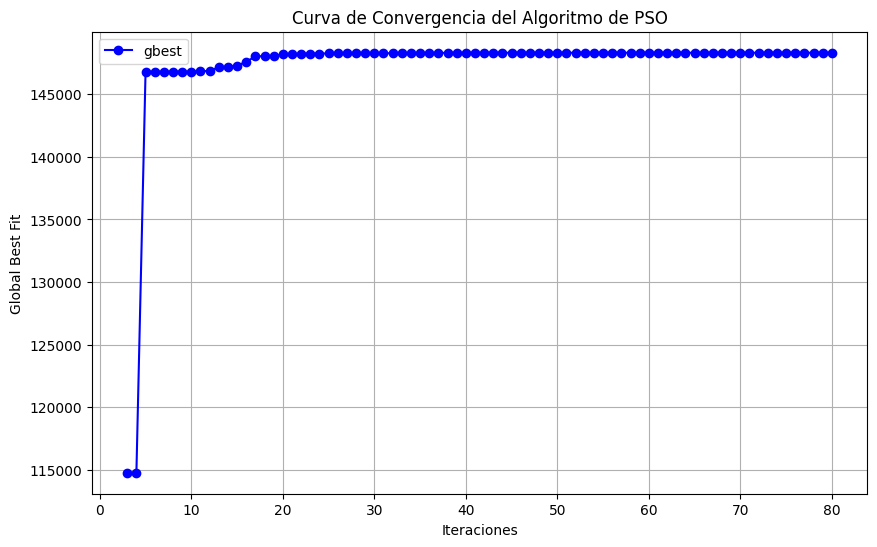

In [147]:
# Graficar el histórico de gbest en función de las iteraciones
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_iterations + 1), mejor_historico, marker='o', linestyle='-', color='b', label='gbest')
plt.title('Curva de Convergencia del Algoritmo de PSO')
plt.xlabel('Iteraciones')
plt.ylabel('Global Best Fit')
plt.legend()
plt.grid()
plt.show()

Bajo estas condiciones, el algoritmo parece converger al máximo global de forma más rápida que en el caso anterior.

**f. (Valor 1 puntos) Realizar 3 boxplots a partir de los gbest de 3 variantes de solución: i) El primer boxplot con el coeficiente de inercia constante w = 0.9, ii) El segundo boxplot con el coeficiente de inercia dinámico lineal y iii) El tercer boxplot sin coeficiente de inercia pero aplicando Factor de constricción con φ = 3.**

Solución:

- Optimizamos para la primera variante con w=0.9:

In [148]:
w = 0.9

# Ejecutar el PSO 100 veces y guardar los resultados
num_rodadas = 100
resultados_rodadas = []

for _ in range(num_rodadas):
    gbest, gbest_fit, gbest_fit_iterations = pso_maximizacion()
    resultados_rodadas.append((gbest, gbest_fit, gbest_fit_iterations))

# Seleccionar la mejor solución de todas las rodadas
mejor_solucion, mejor_valor, mejor_historico = max(resultados_rodadas, key=lambda x: x[1])

# Redondear los valores de la mejor solución al entero más cercano
mejor_solucion_redondeada = np.round(mejor_solucion)

# Imprimir la mejor solución encontrada
print(f"Mejor solucion: [{mejor_solucion_redondeada[0]}, {mejor_solucion_redondeada[1]}]")
print(f"Valor optimo: {mejor_valor}")

Mejor solucion: [107.0, 238.0]
Valor optimo: 148296.41948126393


No se observan cambios en los resultados obtenidos, pero sí una mejora en la rapidez de convergencia como muestra el siguiente gráfico:

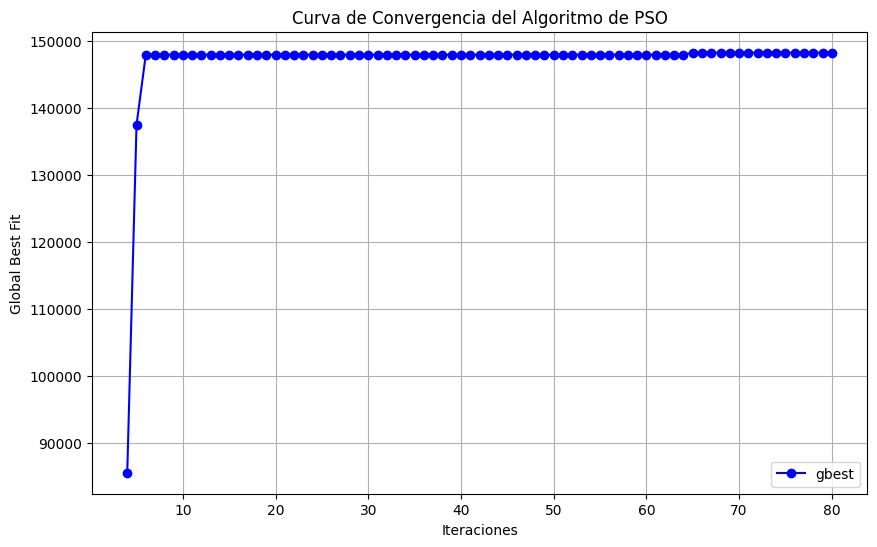

In [149]:
# Graficar el histórico de gbest en función de las iteraciones
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_iterations + 1), mejor_historico, marker='o', linestyle='-', color='b', label='gbest')
plt.title('Curva de Convergencia del Algoritmo de PSO')
plt.xlabel('Iteraciones')
plt.ylabel('Global Best Fit')
plt.legend()
plt.grid()
plt.show()

Así, se grafica el boxplot para esta configurtación:

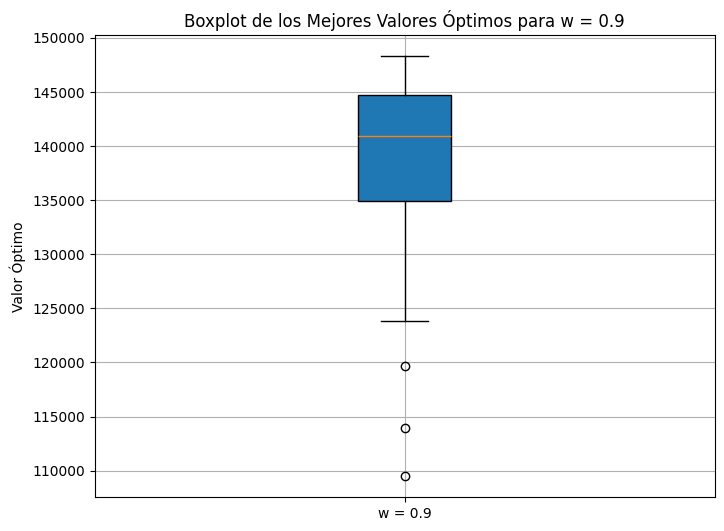

In [150]:
# Extraer los valores óptimos de los resultados obtenidos
resultados_vi = [resultado[1] for resultado in resultados_rodadas]  # Aquí usamos los valores óptimos reales

# Crear el boxplot para los resultados reales
plt.figure(figsize=(8, 6))
plt.boxplot(resultados_vi, patch_artist=True, labels=['w = 0.9'])

# Añadir títulos y etiquetas
plt.title('Boxplot de los Mejores Valores Óptimos para w = 0.9')
plt.ylabel('Valor Óptimo')
plt.grid()

# Mostrar el gráfico
plt.show()

- Optimizamos para la segunda variante, usando un coeficiente de inercia dinámico lineal.

Para ello, se redefine el algoritmo PSO de la siguiente forma, para considerar un coeficiente de inercia dinámico lineal, de forma semejante al ejercicio anterior:

In [151]:
# Función que ejecuta el PSO con restricciones y coeficiente de inercia dinámico lineal
def pso_max_dinamico():
    # Parámetros de inercia
    w_inicio = 0.9  # Coeficiente de inercia inicial
    w_fin = 0     # Coeficiente de inercia final

    # Inicialización de partículas
    x = np.zeros((n_particles, n_dimensions))
    v = np.zeros((n_particles, n_dimensions))
    pbest = np.zeros((n_particles, n_dimensions))
    pbest_fit = -np.inf * np.ones(n_particles)
    gbest = np.zeros(n_dimensions)
    gbest_fit = -np.inf

    # Inicializar partículas factibles
    for i in range(n_particles):
        while True:
            x[i] = np.random.uniform(0, 500, n_dimensions)  # Limitar la cantidad de producción a un rango razonable
            if capital_restriccion(x[i]) and mano_obra_restriccion(x[i]):
                break
        v[i] = np.random.uniform(-1, 1, n_dimensions)
        pbest[i] = x[i].copy()
        fit = utilidad(x[i])
        if fit > pbest_fit[i]:
            pbest_fit[i] = fit

    # Optimización
    gbest_fit_iterations = []
    for iter_num in range(max_iterations):
        # Actualizar el coeficiente de inercia de forma lineal
        w = w_inicio - ((w_inicio - w_fin) * (iter_num / max_iterations))

        for i in range(n_particles):
            fit = utilidad(x[i])
            # Comprobar si la nueva aptitud es mejor y cumple las restricciones
            if fit > pbest_fit[i] and capital_restriccion(x[i]) and mano_obra_restriccion(x[i]):
                pbest_fit[i] = fit
                pbest[i] = x[i].copy()
                if fit > gbest_fit:
                    gbest_fit = fit
                    gbest = x[i].copy()

            # Actualización de la velocidad y la posición de la partícula con inercia dinámica
            r1, r2 = np.random.rand(), np.random.rand()
            v[i] = w * v[i] + c1 * r1 * (pbest[i] - x[i]) + c2 * r2 * (gbest - x[i])
            x[i] += v[i]

            # Limitar las cantidades a un mínimo de 0 (no se pueden producir cantidades negativas)
            x[i] = np.clip(x[i], 0, None)

            # Revertir la actualización si las restricciones no se cumplen
            if not (capital_restriccion(x[i]) and mano_obra_restriccion(x[i])):
                x[i] = pbest[i].copy()

        gbest_fit_iterations.append(gbest_fit)

    return gbest, gbest_fit, gbest_fit_iterations


Se ejecuta el algoritmo con las modificaciones:

In [152]:
# Ejecutar el PSO 100 veces y guardar los resultados
num_rodadas = 100
resultados_rodadas = []

for _ in range(num_rodadas):
    gbest, gbest_fit, gbest_fit_iterations = pso_max_dinamico()
    resultados_rodadas.append((gbest, gbest_fit, gbest_fit_iterations))

# Seleccionar la mejor solución de todas las rodadas
mejor_solucion, mejor_valor, mejor_historico = max(resultados_rodadas, key=lambda x: x[1])

# Redondear los valores de la mejor solución al entero más cercano
mejor_solucion_redondeada = np.round(mejor_solucion)

# Imprimir la mejor solución encontrada
print(f"Mejor solucion: [{mejor_solucion_redondeada[0]}, {mejor_solucion_redondeada[1]}]")
print(f"Valor optimo: {mejor_valor}")

Mejor solucion: [107.0, 237.0]
Valor optimo: 148311.99245728162


Tampoco se observan cambios significativos en los resultados obtenidos. Sin embargo, el rendimiento del modelo parece empeorar como se muestra en el siguiente gráfico, donde la convergencia se obtiene despues de unas 60 iteraciones:

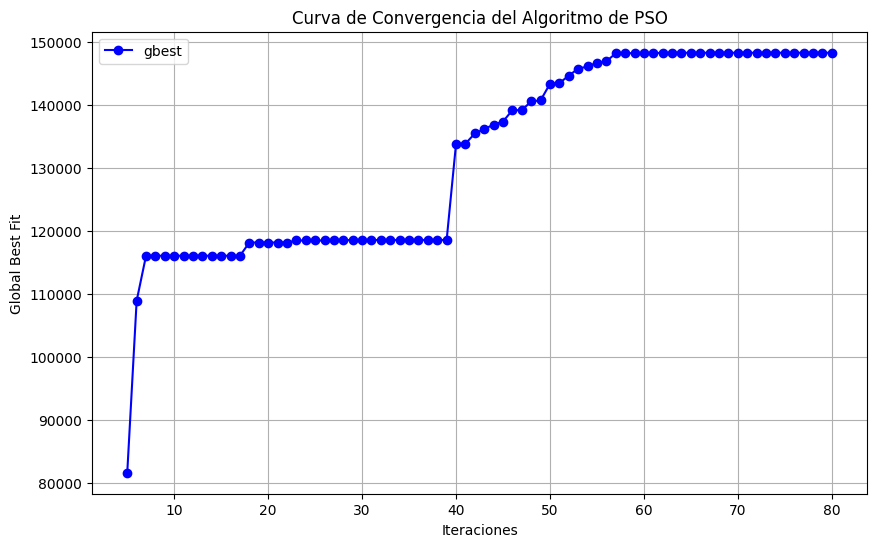

In [153]:
# Graficar el histórico de gbest en función de las iteraciones
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_iterations + 1), mejor_historico, marker='o', linestyle='-', color='b', label='gbest')
plt.title('Curva de Convergencia del Algoritmo de PSO')
plt.xlabel('Iteraciones')
plt.ylabel('Global Best Fit')
plt.legend()
plt.grid()
plt.show()

Así, se grafica el boxplot para esta configurtación:

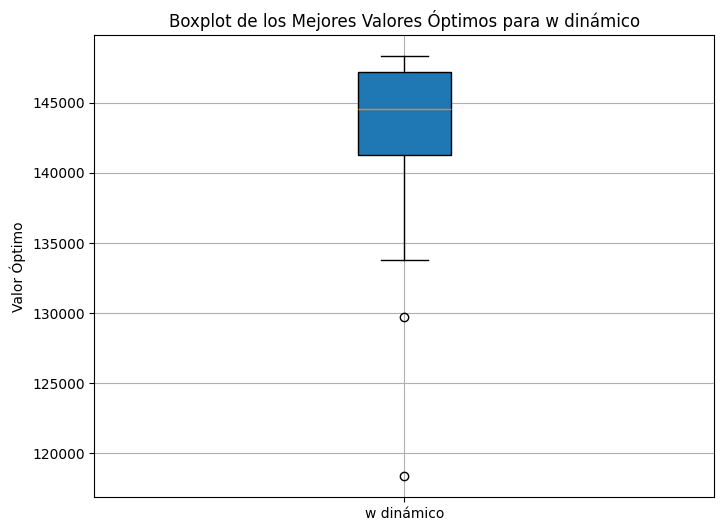

In [154]:
# Extraer los valores óptimos de los resultados obtenidos
resultados_vii = [resultado[1] for resultado in resultados_rodadas]  # Aquí usamos los valores óptimos reales

# Crear el boxplot para los resultados reales
plt.figure(figsize=(8, 6))
plt.boxplot(resultados_vii, patch_artist=True, labels=['w dinámico'])

# Añadir títulos y etiquetas
plt.title('Boxplot de los Mejores Valores Óptimos para w dinámico')
plt.ylabel('Valor Óptimo')
plt.grid()

# Mostrar el gráfico
plt.show()

- Optimizamos para la tercera variante, sin coeficiente de inercia pero aplicando Factor de constricción con φ = 3.

Nuevamente, se debe reescribir el algoritmo PSO como en el ejercicio anterior para considerar un Factor de constricción sin coeficiente de inercia. No obstante, no es posible usar φ = 3 ya que esto produciría una raíz imaginaria en el Factor de constricción que indeterminaría los resultados:

In [158]:
# Función que ejecuta el PSO con restricciones y factor de constricción
def pso_max_constriccion():
    # Parámetros del factor de constricción
    c1 = c2 = 2.05
    phi = c1 + c2
    chi = 2 / abs(phi - 2 + np.sqrt(phi**2 - 4 * phi))

    # Inicialización de partículas
    x = np.zeros((n_particles, n_dimensions))
    v = np.zeros((n_particles, n_dimensions))
    pbest = np.zeros((n_particles, n_dimensions))
    pbest_fit = -np.inf * np.ones(n_particles)
    gbest = np.zeros(n_dimensions)
    gbest_fit = -np.inf

    # Inicializar partículas factibles
    for i in range(n_particles):
        while True:
            x[i] = np.random.uniform(0, 500, n_dimensions)  # Limitar la cantidad de producción a un rango razonable
            if capital_restriccion(x[i]) and mano_obra_restriccion(x[i]):
                break
        v[i] = np.random.uniform(-1, 1, n_dimensions)
        pbest[i] = x[i].copy()
        fit = utilidad(x[i])
        if fit > pbest_fit[i]:
            pbest_fit[i] = fit

    # Optimización
    gbest_fit_iterations = []
    for _ in range(max_iterations):
        for i in range(n_particles):
            fit = utilidad(x[i])
            # Comprobar si la nueva aptitud es mejor y cumple las restricciones
            if fit > pbest_fit[i] and capital_restriccion(x[i]) and mano_obra_restriccion(x[i]):
                pbest_fit[i] = fit
                pbest[i] = x[i].copy()
                if fit > gbest_fit:
                    gbest_fit = fit
                    gbest = x[i].copy()

            # Actualización de la velocidad y la posición de la partícula con factor de constricción
            r1, r2 = np.random.rand(), np.random.rand()
            v[i] = chi * (c1 * r1 * (pbest[i] - x[i]) + c2 * r2 * (gbest - x[i]))
            x[i] += v[i]

            # Limitar las cantidades a un mínimo de 0 (no se pueden producir cantidades negativas)
            x[i] = np.clip(x[i], 0, None)

            # Revertir la actualización si las restricciones no se cumplen
            if not (capital_restriccion(x[i]) and mano_obra_restriccion(x[i])):
                x[i] = pbest[i].copy()

        gbest_fit_iterations.append(gbest_fit)

    return gbest, gbest_fit, gbest_fit_iterations


Se ejecuta el algoritmo con las modificaciones:

In [159]:
# Ejecutar el PSO 100 veces y guardar los resultados
num_rodadas = 100
resultados_rodadas = []

for _ in range(num_rodadas):
    gbest, gbest_fit, gbest_fit_iterations = pso_max_constriccion()
    resultados_rodadas.append((gbest, gbest_fit, gbest_fit_iterations))

# Seleccionar la mejor solución de todas las rodadas
mejor_solucion, mejor_valor, mejor_historico = max(resultados_rodadas, key=lambda x: x[1])

# Redondear los valores de la mejor solución al entero más cercano
mejor_solucion_redondeada = np.round(mejor_solucion)

# Imprimir la mejor solución encontrada
print(f"Mejor solucion: [{mejor_solucion_redondeada[0]}, {mejor_solucion_redondeada[1]}]")
print(f"Valor optimo: {mejor_valor}")

Mejor solucion: [106.0, 238.0]
Valor optimo: 148195.19538370095


Tampoco se observan cambios significativos en los resultados obtenidos. Sin embargo, el rendimiento del modelo mejora un poco en relación a la variante anterior como se muestra en el siguiente gráfico, donde la convergencia se obtiene despues de unas 15 iteraciones:

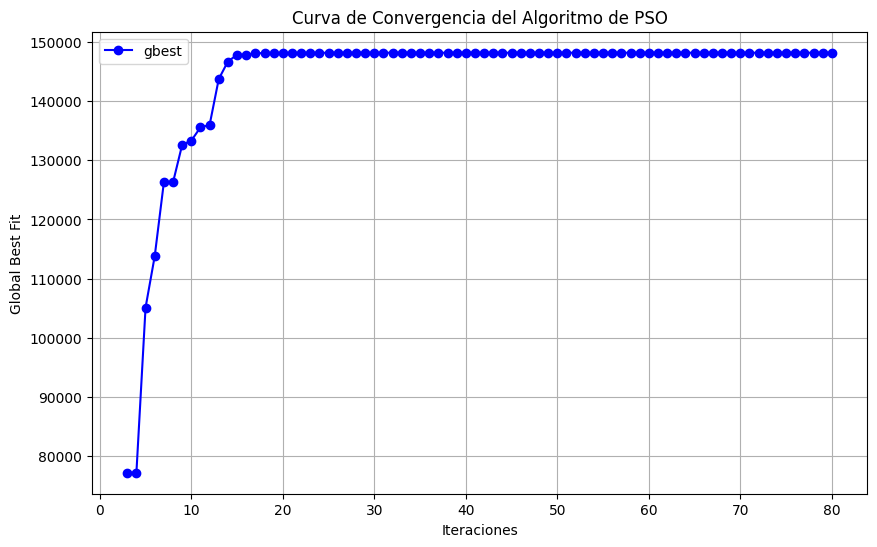

In [160]:
# Graficar el histórico de gbest en función de las iteraciones
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_iterations + 1), mejor_historico, marker='o', linestyle='-', color='b', label='gbest')
plt.title('Curva de Convergencia del Algoritmo de PSO')
plt.xlabel('Iteraciones')
plt.ylabel('Global Best Fit')
plt.legend()
plt.grid()
plt.show()

Así, se grafica el boxplot para esta configurtación:

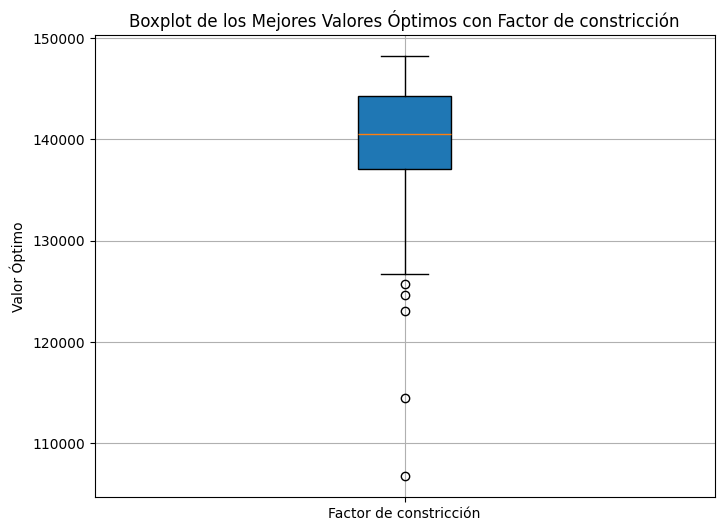

In [161]:
# Extraer los valores óptimos de los resultados obtenidos
resultados_viii = [resultado[1] for resultado in resultados_rodadas]  # Aquí usamos los valores óptimos reales

# Crear el boxplot para los resultados reales
plt.figure(figsize=(8, 6))
plt.boxplot(resultados_viii, patch_artist=True, labels=['Factor de constricción'])

# Añadir títulos y etiquetas
plt.title('Boxplot de los Mejores Valores Óptimos con Factor de constricción')
plt.ylabel('Valor Óptimo')
plt.grid()

# Mostrar el gráfico
plt.show()

El gráfico con los boxplots que compara los mejores valores óptimos obtenidos con las tres variantes se muestra a continuación:

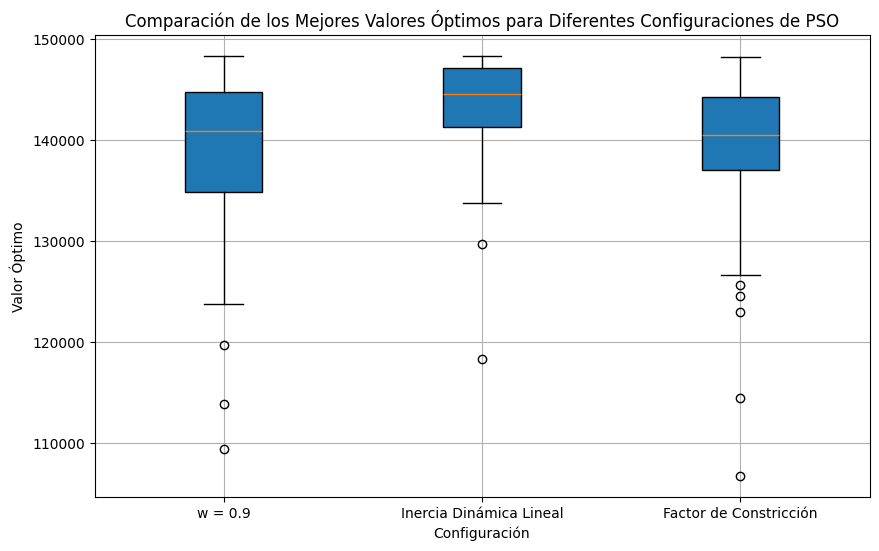

In [162]:
# Crear el boxplot para comparar los tres conjuntos de resultados reales
plt.figure(figsize=(10, 6))
plt.boxplot([resultados_vi, resultados_vii, resultados_viii], patch_artist=True,
            labels=['w = 0.9', 'Inercia Dinámica Lineal', 'Factor de Constricción'])

# Añadir títulos y etiquetas
plt.title('Comparación de los Mejores Valores Óptimos para Diferentes Configuraciones de PSO')
plt.ylabel('Valor Óptimo')
plt.xlabel('Configuración')
plt.grid()

# Mostrar el gráfico
plt.show()

**g. (Valor 1 punto) Realizar observaciones/comentarios/conclusiones en el .pdf acerca de los resultados del ítem (f).**

Solución:

El gráfico que compara los boxplots de las 3 configuraciones indica que:

- Las medianas de los valores óptimos (línea naranja) son semejantes para w=0.9 y con factor de  constricción, pero la configuración con una inercia dinámica lineal tiene una mediana superior, lo que sugiere que, en promedio, esta configuración tiende a encontrar mejores valores óptimos en comparación con las otras dos.

- La dispersión o variabilidad en los valores óptimos obtenidos (tamaño de las cajas) es menor en la configuración con inercia dinámica lineal y mayor con w=0.9. En esta última configuración, esto significa que con w=0.9 se explora más el espacio de búsqueda, lo que puede llevar a resultados óptimos más altos en algunas ejecuciones.

- El rango de valores (barras verticales) es más estrecho para el caso de la variante con inercia dinámica lineal, indicando que la mayoría de los resultados se concentran en un rango específico entre 135 mil y 147 mil aproximadamente. Por su parte, la variante con w=0.9 tiene un rango más amplio, pero con una barra inferior más larga, lo que sugiere que en algunas ejecuciones el PSO encontró valores óptimos más bajos.

- Hay algunos valores atípicos en todas las configuraciones, lo que sugiere que hay valores bajos que se alejan significativamente del rango principal de resultados. Estos valores atípicos pueden ocurrir debido a exploraciones que encontraron soluciones subóptimas.

Por lo anterior, si se busca estabilidad y consistencia en los resultados, además de valores óptimos más altos, la configuración con inercia dinámica lineal sería la mejor elección, aunque la convergencia es más lenta en comparación con las otras variantes.


**h. (Valor 1 punto) Realizar observaciones/comentarios/conclusiones en el .pdf acerca de qué cantidad mínima de partículas es factible utilizar para este problema específicamente.**

Solución:

Teniendo en cuenta que el problema tiene dos variables (las cantidades de impresoras tipo 1 y tipo 2), y dos restricciones lineales (capital y mano de obra disponibles), y que la función objetivo y las restricciones son lineales, lo que simplifica el espacio de búsqueda, entonces un número de partículas equivalente a dos veces el número de dimensiones podría ser suficiente para cubrir el espacio de soluciones de manera efectiva.

Sin embargo, nuestros resultados con 10 partículas muestran que esta cantidad de partículas es suficiente para que el PSO converja a una buena solución. Esto se debe a que el espacio de búsqueda no es demasiado complejo y las restricciones no agregan una dificultad significativa.

Disminuir el número de partículas por debajo de 10 podría hacer que el PSO pierda la diversidad necesaria para encontrar soluciones cercanas al óptimo global de manera consistente. Del mismo modo incrementar el número de forma exagerada solo produce una mejora marginal en la calidad de la solución, pues a partir de cierto punto, agregar más partículas solo incrementa el tiempo de cómputo sin aportar beneficios significativos en la solución.

Por lo tanto consideramos que para este problema, un número de partículas entre 10 y 20 parece ser una buena elección. Este rango permite un balance adecuado entre la exploración del espacio de búsqueda y la eficiencia computacional.
